<a href="https://colab.research.google.com/github/Ewerton-Miranda/ANALISEIMAGEM_HSV-e-YCrCb/blob/main/ANALISEIMAGEM_HSV_e_YCrCb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dimensões da imagem original: 1599x899
Tonalidade da pele: Parda

Imagens lado a lado:


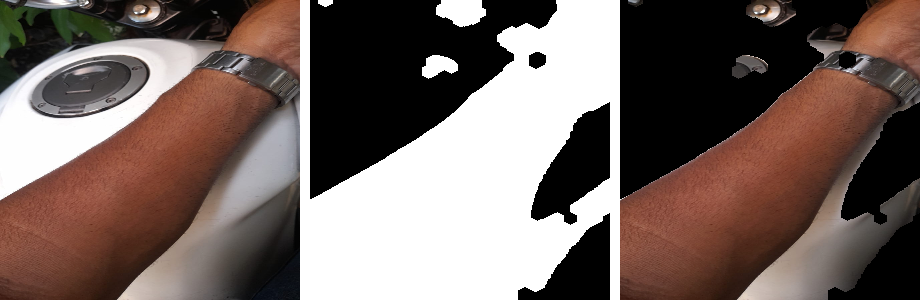

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import pandas as pd
import plotly.graph_objects as go

def detect_skin(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    ycrcb_image = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)

    lower_hsv_skin = np.array([0, 20, 40], dtype=np.uint8)
    upper_hsv_skin = np.array([20, 255, 255], dtype=np.uint8)

    lower_ycrcb_skin = np.array([0, 130, 80], dtype=np.uint8)
    upper_ycrcb_skin = np.array([255, 180, 130], dtype=np.uint8)

    mask_hsv = cv2.inRange(hsv_image, lower_hsv_skin, upper_hsv_skin)
    mask_ycrcb = cv2.inRange(ycrcb_image, lower_ycrcb_skin, upper_ycrcb_skin)

    skin_mask = cv2.bitwise_and(mask_hsv, mask_ycrcb)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    skin_mask = cv2.morphologyEx(skin_mask, cv2.MORPH_OPEN, kernel, iterations=3)

    skin_detected = cv2.bitwise_and(image, image, mask=skin_mask)

    return skin_detected, skin_mask

def determine_skin_tone(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    v_channel = hsv_image[:, :, 2]

    skin_pixels = v_channel[np.where(v_channel > 0)]

    skin_mean = np.mean(skin_pixels)

    limiar_clara = 150
    limiar_parda = 100
    limiar_negra = 50

    if skin_mean > limiar_clara:
        return "Clara"
    elif skin_mean > limiar_parda:
        return "Parda"
    elif skin_mean > limiar_negra:
        return "Negra"
    else:
        return "Muito Negra"

def get_color_name(rgb):
    colors = {
        "vermelho": [255, 0, 0],
        "verde": [0, 255, 0],
        "azul": [0, 0, 255],
        "amarelo": [255, 255, 0],
        "ciano": [0, 255, 255],
        "magenta": [255, 0, 255],
        "branco": [255, 255, 255],
        "preto": [0, 0, 0],
        "cinza": [128, 128, 128]
    }

    min_diff = float('inf')
    closest_color = "desconhecido"

    for color_name, color_rgb in colors.items():
        diff = np.linalg.norm(np.array(rgb) - np.array(color_rgb))
        if diff < min_diff:
            min_diff = diff
            closest_color = color_name

    return closest_color.capitalize()

def get_rgb_from_color_name(color_name):
    colors = {
        "Vermelho": [255, 0, 0],
        "Verde": [0, 255, 0],
        "Azul": [0, 0, 255],
        "Amarelo": [255, 255, 0],
        "Ciano": [0, 255, 255],
        "Magenta": [255, 0, 255],
        "Branco": [255, 255, 255],
        "Preto": [0, 0, 0],
        "Cinza": [128, 128, 128]
    }
    return colors.get(color_name.capitalize(), [255, 255, 255])

def create_interactive_table():
    hsv_data = [
        {"Espaço de cor": "HSV", "Limite": "Inferior", "Valor": [0, 20, 40], "Nome da cor": get_color_name([0, 20, 40])},
        {"Espaço de cor": "HSV", "Limite": "Superior", "Valor": [20, 255, 255], "Nome da cor": get_color_name([20, 255, 255])},
    ]

    ycrcb_data = [
        {"Espaço de cor": "YCrCb", "Limite": "Inferior", "Valor": [0, 130, 80], "Nome da cor": get_color_name([0, 130, 80])},
        {"Espaço de cor": "YCrCb", "Limite": "Superior", "Valor": [255, 180, 130], "Nome da cor": get_color_name([255, 180, 130])},
    ]

    hsv_df = pd.DataFrame(hsv_data)
    ycrcb_df = pd.DataFrame(ycrcb_data)

    def create_table(df, title):
        colors = [get_rgb_from_color_name(name) for name in df['Nome da cor']]
        rgba_colors = [f'rgba({c[0]}, {c[1]}, {c[2]}, 0.7)' for c in colors]

        fig = go.Figure(data=[go.Table(
            header=dict(values=list(df.columns),
                        fill_color='darkslategray',
                        font=dict(color='white', size=24),  # Aumentando o tamanho da fonte do cabeçalho
                        align='center',
                        line_color='white'),
            cells=dict(values=[df[col] for col in df.columns],
                       fill_color=[rgba_colors],
                       font=dict(color='white', size=20),  # Aumentando o tamanho da fonte das células
                       align='center',
                       line_color='white'))
        ])
        fig.update_layout(
            title=dict(text=title, x=0.5, xanchor='center'),
            margin=dict(l=10, r=10, t=50, b=10),
            height=700,  # Aumentando a altura da tabela para acomodar melhor o conteúdo
            paper_bgcolor='lightgrey'
        )
        return fig

    hsv_table = create_table(hsv_df, 'Intervalos HSV')
    ycrcb_table = create_table(ycrcb_df, 'Intervalos YCrCb')

    # Exibe as tabelas interativas
    hsv_table.show()
    ycrcb_table.show()

def main():
    image_path = '/content/sample_data/WhatsApp Image 2024-09-04 at 08.32.55.jpeg'
    image = cv2.imread(image_path)

    if image is None:
        print("Erro ao carregar a imagem.")
        return

    original_dimensions = image.shape[:2]
    print(f"Dimensões da imagem original: {original_dimensions[0]}x{original_dimensions[1]}")

    image = cv2.resize(image, (300, 300))
    skin_detected, skin_mask = detect_skin(image)

    tonalidade = determine_skin_tone(skin_detected)
    print("Tonalidade da pele:", tonalidade)

    skin_mask_color = cv2.cvtColor(skin_mask, cv2.COLOR_GRAY2BGR)

    spacer = np.ones((300, 10, 3), dtype=np.uint8) * 255

    combined_image = np.hstack((image, spacer, skin_mask_color, spacer, skin_detected))

    print("\nImagens lado a lado:")
    cv2_imshow(combined_image)

    create_interactive_table()

if __name__ == "__main__":
    main()








































































